<a href="https://www.kaggle.com/code/shobhiii/training-a-masked-auto-encoder?scriptVersionId=230405124" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Load dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score, roc_curve
from einops import rearrange, repeat

### Patch Embedding Layer  
This class divides an input image into fixed-size patches and projects them into a lower-dimensional embedding space using a convolutional layer. The output is a sequence of patch embeddings used as input for Vision Transformers.

In [2]:
class PatchEmbed(nn.Module):
    def __init__(self,
                img_size = 224,
                patch_size = 16,
                in_chans = 3,
                embed_dim = 768):
        super().__init__()
        self.img_size = (img_size, img_size)
        self.patch_size = (patch_size, patch_size)
        self.num_patches = (img_size//patch_size)**2

        self.proj = nn.Conv2d(in_chans,
                              embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

### Transformer Encoder  
This class implements a standard Transformer encoder composed of multiple Transformer blocks. It processes only visible (unmasked) patches, applying self-attention and feedforward layers sequentially, followed by layer normalization.


In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                embed_dim = 768,
                depth = 12,
                num_heads = 12,
                mlp_ratio = 4,
                qkv_bias = True,
                drop_rate = 0.,
                attn_drop_rate = 0.,
                drop_path_rate = 0.):
        super().__init__()
        # Create a sequence of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim = embed_dim,
                num_heads = num_heads,
                mlp_ratio = mlp_ratio,
                qkv_bias = qkv_bias,
                drop = drop_rate,
                attn_drop = attn_drop_rate,
                # Stocastic depth: gradually increase drop_path rate for deeper blocks
                drop_path = drop_path_rate*i/depth)
            for i in range(depth)])
        self.norm = nn.LayerNorm(embed_dim) # Final norm Layer

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return x

### Transformer Block  
This class defines a single Transformer block, which consists of a multi-head self-attention mechanism followed by a feedforward MLP. It includes layer normalization and residual connections to improve training stability and performance.


In [4]:
class TransformerBlock(nn.Module):
    def __init__(self,
                dim,
                num_heads,
                mlp_ratio = 4.,
                qkv_bias = False,
                drop = 0.,
                attn_drop = 0.,
                drop_path = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim) #First Layer Norm
        self.attn = Attention(dim,
                              num_heads = num_heads,
                             qkv_bias = qkv_bias,
                             attn_drop = attn_drop,
                             proj_drop = drop) #Multi-Head attention
        
        self.norm2 = nn.LayerNorm(dim) #Second Layer Norm
        mlp_hidden_dim = int(dim * mlp_ratio) # Hidden dimentions of MLP
        self.mlp = Mlp(in_features = dim,
                      hidden_features = mlp_hidden_dim,
                      drop = drop)
    def forward(self, x):
        x = x + self.attn(self.norm1(x)) #Self-attention block with residual connection
        x = x + self.mlp(self.norm2(x)) #Mlp Block with residual connection
        return x

### Multi-Head Self-Attention  
This class implements the multi-head self-attention mechanism, computing relationships between all tokens in a sequence. It projects inputs to query, key, and value representations, applies scaled dot-product attention, and then projects back to the original embedding dimension.


In [5]:
class Attention(nn.Module):
    def __init__(self,
                dim,
                num_heads = 8,
                qkv_bias = False,
                attn_drop = 0.,
                proj_drop = 0.):
        super().__init__()
        self.num_heads = num_heads 
        head_dim = dim//num_heads 
        self.scale = head_dim ** -0.5 
        
        #Linear Proj for Q,K,V for all heads simultaneously
        self.qkv = nn.Linear(dim, dim*3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop) # Dropout for attention Matrix
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)  # Dropout for output Projection

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C//self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2] #Shape: [B, H, N, C/H]

        # Compute scaled dot-product attention
        # (q@k.transpose) calculates similarity between query and key vectors
        attn = (q@k.transpose(-2, -1))*self.scale #B, H, N, N
        attn = attn.softmax(dim = -1)
        attn = self.attn_drop(attn)

        # Apply attention weights to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        #Project back to embeding dimention
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

### Multi-Layer Perceptron (MLP)  
This class implements a simple feedforward network with one hidden layer, using GELU activation. It consists of two linear layers with dropout for regularization, commonly used in Transformer-based architectures.


In [6]:
class Mlp(nn.Module):
    def __init__(self,
                in_features,
                hidden_features = None,
                out_features = None,
                drop = 0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        # Two-Layer MLP
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Transformer Decoder  
This class reconstructs the full image from encoded visible patches and mask tokens using a sequence of Transformer blocks. It applies self-attention and feedforward layers, followed by layer normalization, to decode the input tokens.


In [7]:
class TransformerDecoder(nn.Module):
    def __init__(self,
                embed_dim = 768,
                depth = 8,
                num_heads = 16,
                mlp_ratio = 4.,
                qkv_bias = True,
                drop_rate = 0.,
                attn_drop_rate = 0.,
                drop_path_rate = 0.):
        super().__init__()
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim = embed_dim,
                num_heads = num_heads,
                mlp_ratio = mlp_ratio,
                qkv_bias = qkv_bias,
                drop = drop_rate,
                attn_drop = attn_drop_rate,
                drop_path = drop_path_rate * i / depth
            ) for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        for block in self.blocks:
            x  = block(x)
        x = self.norm(x)
        return x
        

### Masked Autoencoder (MAE)  
This class implements a Masked Autoencoder, a self-supervised learning model that reconstructs images by randomly masking patches and predicting the missing content. It consists of an encoder for visible patches, a decoder for reconstructing the full image, and a loss function that focuses on masked regions.


In [8]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self,
                img_size = 224,
                patch_size = 16,
                in_chans = 3,
                embed_dim = 1024,
                depth = 24,
                num_heads = 16,
                decoder_embed_dim = 512,
                decoder_depth = 8,
                decoder_num_heads = 16,
                mlp_ratio = 4.,
                norm_layer = nn.LayerNorm):
        super().__init__()
        # Encoder Components
        # PatchEmbed splits the image into patches and embeds them
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.num_patches = self.patch_embed.num_patches

        # Class token and Positional Encoding for encoder
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        # Encoder for the visible Patches
        self.encoder = TransformerEncoder(
            embed_dim = embed_dim,
            depth = depth,
            num_heads = num_heads,
            mlp_ratio = mlp_ratio
        )

        # Decoder components
        # Convert the encoder output to decoder dimension
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias = True)
        # Learnable mask token that is used for masked patches
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        # Positional encoding ffor the decoder
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim))
        
        # Decoder to reconstruct the full image
        self.decoder = TransformerDecoder(
            embed_dim = decoder_embed_dim,
            depth = decoder_depth,
            num_heads = decoder_num_heads,
            mlp_ratio = mlp_ratio
            )
        # Final prediction Layer: predict pixel values for eeach patch
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias = True)
        
        # Initialize weights for all components
        self.initialize_weights()

        # Store model parameters for later use
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.img_size = img_size

    def initialize_weights(self):
        pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, self.pos_embed.shape[2]))
        decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, self.decoder_pos_embed.shape[2]))
        
        
        # Use truncated normal distributions 
        nn.init.trunc_normal_(self.pos_embed, std = 0.02)
        nn.init.trunc_normal_(self.decoder_pos_embed, std = 0.02)

        nn.init.trunc_normal_(self.cls_token, std = 0.02)
        nn.init.trunc_normal_(self.mask_token, std = 0.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std = 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        N, L, D = x.shape # Batch, length, dimension
        len_keep = int(L * (1 - mask_ratio)) # Number of patches to keep

        # Generate uniform random noise for each patch in each sample
        noise = torch.rand(N, L, device = x.device) 

        # Sort noise to determine which patches to keep/remove
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Keep the first len_keep patches (lowest noise values)
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index = ids_keep.unsqueeze(-1).repeat(1, 1, D))

        mask = torch.ones([N, L], device = x.device)
        mask[:, :len_keep] = 0
        # Unshuffle to get the binary mask for original sequence
        mask = torch.gather(mask, dim = 1, index = ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # Convert img to patches
        x = self.patch_embed(x)
    
        # Add positional embeddings
        cls_token = self.cls_token + self.pos_embed[:, :1, :]  # [1, 1, D]
        x = x + self.pos_embed[:, 1:, :]  # [B, N, D]
    
        # Apply random masking
        x, mask, ids_restore = self.random_masking(x, mask_ratio)  # [B, N', D]

        # Expand class token to match batch size
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)  # [B, 1, D]

        # Concatenate cls_token and image tokens
        x = torch.cat((cls_tokens, x), dim=1)  # [B, N'+1, D]

        # Process through transformer encoder
        x = self.encoder(x)

        return x, mask, ids_restore


    def forward_decoder(self, x, ids_restore):
        # embed the encoder output
        x = self.decoder_embed(x)

        # add mask tokens
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)

        # exclude class token x[:, 1:] and append mask tokens
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim = 1)

        # unshuffle: restore the original sequence order
        x_ = torch.gather(x_, dim = 1, index = ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))

        # append class token
        x = torch.cat([x[:, :1, :], x_], dim = 1)

        # apply positional embedding 
        x = x + self.decoder_pos_embed

        # apply transformer decoder 
        x = self.decoder(x)

        # predict pixel values for each patch
        x = self.decoder_pred(x)

        # remove class token from prediictions
        x = x[:, 1:, :]

        return x

    def forward(self, imgs, mask_ratio = 0.75):
        # Forward Pass the entire MAE model

        # run encoder on the images with masking
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)

        # run decoder to predict all patches
        pred = self.forward_decoder(latent, ids_restore)

        # convert input images to patches for loss calculation
        target = self.patchify(imgs)

        # calculate mse loss only for masked patches
        loss = self.calculate_loss(pred, target, mask)

        return loss, pred, mask

    def patchify(self, imgs):
        # convert imgs to patches for calculating loss
        p = self.patch_size
        h = w = self.img_size//p

        x = rearrange(imgs, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        return x

    def unpatchify(self, x):
        p = self.patch_size
        h = w = int(x.shape[1] ** 0.5)

        imgs = rearrange(x, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', h = h, w = w, p1 = p, p2 = p)
        return imgs

    def calculate_loss(self, pred, target, mask):
        # calculate mse loss for masked patches only

        loss = (pred - target)**2
        loss = loss.mean(dim = -1)

        loss = (loss*mask).sum()/mask.sum() 

        return loss

In [9]:
def plot_metrics(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()

### NumpyDataset Loader for Image Classification

This script defines a `NumpyDataset` class to load `.npy` image files, preprocess them (convert to tensor, ensure 3-channel format, resize to 224x224), and apply transformations. It also provides a `create_dataloaders` function to split the dataset into training and validation sets and create DataLoaders for model training.


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

class NumpyDataset(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        self.files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.npy')])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = np.load(self.files[idx])  # Load .npy image
        img = torch.tensor(img, dtype=torch.float32)  # Convert to tensor

        # Ensure shape is (C, H, W)
        if img.dim() == 2:  # If (H, W), add channel dim
            img = img.unsqueeze(0)  # Shape (1, H, W)

        # Convert single-channel to 3-channel
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)  # Shape (3, H, W)

        # Resize to (224, 224)
        img = F.resize(img, (224, 224), antialias=True)

        if self.transforms:
            img = self.transforms(img)  # Apply transforms (normalization should be here)

        return img

# Function to create train and validation dataloaders
def create_dataloaders(path, batch_size=32, shuffle=True, num_workers=4, val_split=0.1, seed=42, val_shuffle=False):
    dataset = NumpyDataset(path, transforms=transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

    # Ensure reproducible random split
    torch.manual_seed(seed)

    # Compute train/val split
    val_size = max(1, int(len(dataset) * val_split))  # Ensure at least 1 sample in validation
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=val_shuffle, num_workers=num_workers)

    return train_loader, val_loader

# Example usage
path = "/kaggle/input/dataset-task-6/Dataset/no_sub"
train_loader, val_loader = create_dataloaders(path)

In [11]:
# # def compute_reconstruction_loss(original, reconstructed):
# #     """Computes per-image MSE loss for ROC-AUC computation."""
# #     mse_loss = torch.nn.functional.mse_loss(original, reconstructed, reduction='none')  # Per-pixel loss
# #     per_image_loss = mse_loss.mean(dim=[1, 2, 3])  # Mean over (C, H, W)
# #     return per_image_loss.cpu().numpy()  # Convert to NumPy for ROC-AUC

# def plot_roc_curve(labels, probs):
#     fpr, tpr, _ = roc_curve(labels, probs)
#     plt.figure(figsize=(6, 6))
#     plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(labels, probs):.4f}")
#     plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random chance)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curve")
#     plt.legend()
#     plt.show()

### MAE Model Training Function

This function trains a Masked Autoencoder (MAE) model using a given dataset. It performs training and validation over multiple epochs, logging losses for both phases. The function also includes commented-out code for computing per-image reconstruction loss and AUC-ROC scores, which can be used for anomaly detection. The model's performance is tracked using average training and validation losses.


In [12]:
def train_mae(model, train_loader, val_loader, optimizer, epochs, device):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0

        # Training loop
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)

            loss, _, _ = model(images)  # Get loss from model

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch[{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Average Training Loss: {avg_train_loss:.4f}")

        # Validation loop (AUC-ROC evaluation)
        model.eval()
        val_loss = 0.0
        all_labels = []  # Ground truth
        all_scores = []  # Reconstruction loss (anomaly scores)

        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)

                loss, pred, mask = model(images)  # Get reconstruction loss, predictions, and mask
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

        model.train()

    # Plot metrics after training
    plot_metrics(train_losses, val_losses)

    return model

In [13]:
# Hyperparamerters
img_size = 224
patch_size = 16
embed_dim = 1024
encoder_depth = 24
encoder_heads = 16
decoder_embed_dim = 512
decoder_depth = 8
decoder_heads = 16
mask_ratio = 0.75

# Create the model
model = MaskedAutoEncoder(
    img_size = img_size,
    patch_size = patch_size,
    embed_dim = embed_dim,
    depth = encoder_depth,
    num_heads = encoder_heads,
    decoder_embed_dim = decoder_embed_dim,
    decoder_depth = decoder_depth,
    decoder_num_heads = decoder_heads
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 1.5e-4, betas = (0.9, 0.95), weight_decay = 0.05)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 100)

Epoch [1/10], Batch[0/829], Loss: 6.2346
Epoch [1/10], Batch[100/829], Loss: 2.0315
Epoch [1/10], Batch[200/829], Loss: 1.8581
Epoch [1/10], Batch[300/829], Loss: 1.7693
Epoch [1/10], Batch[400/829], Loss: 1.4294
Epoch [1/10], Batch[500/829], Loss: 1.5538
Epoch [1/10], Batch[600/829], Loss: 1.3645
Epoch [1/10], Batch[700/829], Loss: 1.2806
Epoch [1/10], Batch[800/829], Loss: 1.2693
Epoch [1/10], Average Training Loss: 1.7367
Epoch [1/10], Validation Loss: 1.3507
Epoch [2/10], Batch[0/829], Loss: 1.2922
Epoch [2/10], Batch[100/829], Loss: 1.4202
Epoch [2/10], Batch[200/829], Loss: 1.3851
Epoch [2/10], Batch[300/829], Loss: 1.2579
Epoch [2/10], Batch[400/829], Loss: 1.1817
Epoch [2/10], Batch[500/829], Loss: 1.2091
Epoch [2/10], Batch[600/829], Loss: 1.0657
Epoch [2/10], Batch[700/829], Loss: 0.9999
Epoch [2/10], Batch[800/829], Loss: 0.5976
Epoch [2/10], Average Training Loss: 1.1816
Epoch [2/10], Validation Loss: 0.9555
Epoch [3/10], Batch[0/829], Loss: 1.1386
Epoch [3/10], Batch[100/8

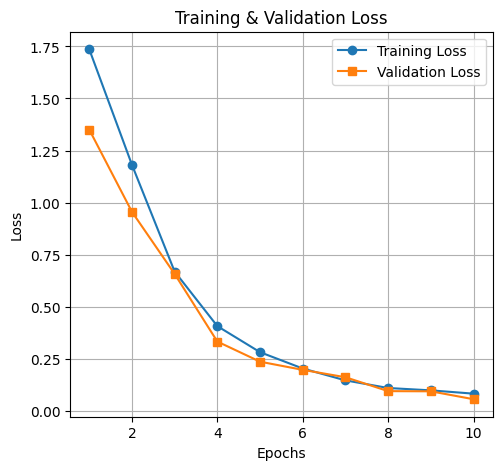

In [14]:
epochs = 10
trained_model = train_mae(model, train_loader,val_loader, optimizer, epochs, device)

In [15]:
torch.save(trained_model.state_dict(), "/kaggle/working/model.pth")